
# Лабораторная 5. Деревья решений


Дерево решений - способ представления правил в иерархической последовательности, где каждому объекту соответствующий узел, дающий решение
*   Узел - признак
*   Ребро - значение признака
* Лист - метка класса


In [ ]:
from random import shuffle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = pd.read_csv("/content/AgaricusLepiota.csv", delimiter = ",")
data

,classes,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


Отобрать случайным образом sqrt(n) признаков

In [ ]:
y_label = "classes"
y_classes = set(data[y_label].to_list())
y_classes_count = len(y_classes)

X_labels_count = int(np.round(np.sqrt(len(data.columns) - 1)))  # Определяем кол-во призков на основе квад. к. из кол-ва столбцов (первый столбец-метка)
X_labels = data.columns[1:].to_list()
shuffle(X_labels)  # перемешивает
X_labels = X_labels[:X_labels_count]

X_attributes = dict()
for label in X_labels:
  X_i_set = set(data[label].to_list())
  X_attributes[label] = X_i_set

print(X_labels_count, X_labels)

5 ['ring_type', 'stalk_surface_above_ring', 'cap_shape', 'population', 'stalk_surface_below_ring']


In [ ]:
# Обрабатываем полученные значения в данных.
# Для каждого признака, содержащего пропущенные значения (обозначенные как "?"), она находит моду этого признака и заменяет все пропущенные значения этим значением
def mode_nulls(data, X_attributes):
  for key in X_attributes:
    if "?" in X_attributes[key]:
      nulls_count = 0
      X_attributes[key] = X_attributes[key] - set("?")

      mode_value = ""
      mode_count = 0
      for value in X_attributes[key]:
        count = data.loc[data[key] == value].shape[0]
        if mode_count < count:
          mode_value = value
          mode_count = count

      for i in range(data.shape[0]):
        if data[key][i] == "?":
          data[key][i] = mode_value
          nulls_count += 1

      print("{} null values in {} changed to {}".format(nulls_count, key, mode_value))
  return data

data = mode_nulls(data, X_attributes)
data_n = data[X_labels + [y_label]]

Реализовать без использования сторонних библиотек построение дерева решений  (дерево не бинарное, numpy и pandas использовать можно, использовать список списков  для реализации  дерева - нельзя)

$ X $ - любой атрибут

$ T $ - исходное множество

$ T_i $ - разбиение множества $ T $ по значениям $ A_1, A_2, ..., A_n $ атрибута $ X $

$ C_j $ - $ j $-й класс $ Y $

$ freq(C_j, T) $ - количество элементов из $ T $ относящихся к классу $ C_j $

Оценка среднего количества информации, необходимого для определения класса примера из множества
$ Info(T) = -\sum_{j=1}^k \frac {freq(C_j, T)} {|T|} \cdot log_2 \frac {freq(C_j, T)} {|T|} $

Оценка среднего количества информации, необходимого для определения класса примера из множества  после разбиения множества
$ Info_X(T) = \sum_{i=1}^n \frac {|T_i|} {|T|} Info(T_i) $

Оценка потенциальной информации, получаемой при разбиении множества T на n подмножеств. Необходим для учета атрибутов с уникальными значениями
$ split_{info_X}(T) = -\sum_{i=1}^n \frac {|T_i|} {|T|} log_2 \frac {|T_i|} {|T|} $

Нормированный прирост информации
$ Gain_{ratio}(X) = \frac {Info(T) - Info_X(T)} {split_{info_X}(T)} $

Критерий Gain_ratio считается для всех атрибутов. Выбирается атрибут с максимальным Gain_ratio. Этот атрибут будет являться проверкой в текущем узле дерева, а затем по этому атрибуту производится дальнейшее построение дерева.

Такие же рассуждения можно применить к полученным подмножествам T_1,T_2,…,T_n и продолжить рекурсивно процесс построения дерева, до тех пор, пока в узле не окажутся примеры из одного класса.


In [ ]:
# Класс, представляющий узел дерева решений.
class DecisionTreeNode:
  def __init__(self, parent_attribute = None, parent_attribute_value = None, attribute = None, entropy = 0.0, samples_count = 0):
    self.parent_attribute = parent_attribute
    self.parent_attribute_value = parent_attribute_value
    self.attribute = attribute
    self.entropy = entropy
    self.samples_count = samples_count
    self.samples = dict()
    self.probability = dict()
    self.prediction = None
    self.children = list()
# Метод для предсказания класса для входного примера X
  def predict(self, X):
    for child in self.children:
      if X[self.attribute] == child.parent_attribute_value:
        return child.predict(X)

    return self.prediction

# Метод для предсказания вероятности классов для входного примера X
  def predict_proba(self, X):
    for child in self.children:
      if X[self.attribute] == child.parent_attribute_value:
        return child.predict_proba(X)

    return self.probability

  def __str__(self):
    key_row, count_row, prob_row = "", "", ""
    for key in sorted(self.probability):
      count_str = "{}".format(self.samples[key])
      prob_str = "{:.5f}".format(self.probability[key])
      max_len = max([len(count_str), len(prob_str), len(key)])
      key_row += " {}{} |".format(" " * (max_len - len(key)), key)
      count_row += " {}{} |".format(" " * (max_len - len(count_str)), count_str)
      prob_row += " {}{} |".format(" " * (max_len - len(prob_str)), prob_str)

    parent_attribute = str(self.parent_attribute)
    parent_attribute_value = str(self.parent_attribute_value)

    row_len = len(key_row) - 1

    hline = "+" + "-" * row_len + "+"
    attr_row = "{}{}".format(parent_attribute, " " * (row_len - len(parent_attribute)))
    attr_val_row = "{}{}".format(parent_attribute_value, " " * (row_len - len(parent_attribute_value)))
    lines = [
        hline,
        "|" + attr_row + "|",
        "|" + attr_val_row + "|",
        "|" + "Count &" + " " * (row_len - 7) + "|",
        "|" + "Probability" + " " * (row_len - 11) + "|",
        hline,
        "|" + key_row,
        hline,
        "|" + count_row,
        hline,
        "|" + prob_row,
        hline
    ]

    return "\n".join(lines)

# Класс для вычисления энтропии и связанных показателей
class InformationEntropy:
  def __init__(self, df: pd.DataFrame, y_label: str):
    self.y_label = y_label
    self.y_classes = set(df[y_label].to_list())
    self.X_values = dict()
    for label in df.columns:
      if label != y_label:
        self.X_values[label] = set(df[label].to_list())
# Метод для подсчета частоты появления класса в данных
  def freq(self, df, C_j):
    return df.loc[df[y_label] == C_j].shape[0]
# Метод для вычисления энтропии для всего набора данных
  def info(self, df):
    if df.shape[0] == 0:
      return 0

    result = 0
    for y_class in self.y_classes:
      freq_c_div_df = self.freq(df, y_class) / df.shape[0]
      if freq_c_div_df == 0:
        continue
      result -= freq_c_div_df * np.log2(freq_c_div_df)
    return result
# Метод для вычисления взвешенной энтропии для конкретного признака
  def info_X(self, df, X_label):
    if df.shape[0] == 0:
      return 0

    result = 0
    for attr in self.X_values[X_label]:
      df_i = df.loc[df[X_label] == attr]
      if df_i.shape[0] == 0:
        continue
      result += df_i.shape[0] * self.info(df_i)
    result /= df.shape[0]
    return result
# Метод для вычисления "split information" для конкретного признака
  def split_info_X(self, df, X_label):
    result = 1e-9
    for attr in self.X_values[X_label]:
      df_i = df.loc[df[X_label] == attr]
      if df_i.shape[0] == 0:
        continue
      df_i_div_df = df_i.shape[0] / df.shape[0]
      result -= df_i_div_df * np.log2(df_i_div_df)
    return result
# Метод для вычисления относительного выигрыша признака
  def gain_ratio_X(self, df, X_label):
    return (self.info(df) - self.info_X(df, X_label)) / self.split_info_X(df, X_label)



# Класс для построения и использования дерева решений
class DecisionTree:
  def __init__(self, max_leaf_entropy = 0.0, max_leaf_samples = 1):
    assert (max_leaf_entropy > 0) or (max_leaf_samples > 0), "Entropy ratio and samples count to define leaf can't be 0 at once"

    self.decision_tree_node = None
    self.max_leaf_entropy = max_leaf_entropy
    self.max_leaf_samples = max_leaf_samples
    self.info_entropy = None
# Рекурсивный метод для построения дерева решений
  def build_tree(self, df: pd.DataFrame, TreeNode: DecisionTreeNode):
    if df.shape[0] == 0:
      return

    best_attr = None
    best_ratio = 0
    for attr in self.info_entropy.X_values:
      ratio = self.info_entropy.gain_ratio_X(df, attr)
      if best_ratio < ratio:
        best_attr = attr
        best_ratio = ratio

    TreeNode.attribute = best_attr
    TreeNode.entropy = best_ratio
    max_samples_count = 0
    for y_class in self.info_entropy.y_classes:
      TreeNode.samples[y_class] = df.loc[df[self.info_entropy.y_label] == y_class].shape[0]
      TreeNode.probability[y_class] = TreeNode.samples[y_class] / df.shape[0]
      if max_samples_count < TreeNode.samples[y_class]:
        max_samples_count = TreeNode.samples[y_class]
        TreeNode.prediction = y_class
    TreeNode.samples_count = df.shape[0]

    if (TreeNode.entropy > self.max_leaf_entropy) and (TreeNode.samples_count > self.max_leaf_samples):
      for attr in self.info_entropy.X_values[best_attr]:
        df_loc = df.loc[df[best_attr] == attr]
        if df_loc.shape[0] > 0:
          child = DecisionTreeNode()
          child.parent_attribute = best_attr
          child.parent_attribute_value = attr
          TreeNode.children.append(child)
          self.build_tree(df_loc, TreeNode.children[-1])
# Метод для обучения дерева решений на данных
  def fit(self, df: pd.DataFrame, y_label: str):
    self.info_entropy = InformationEntropy(df, y_label)
    self.decision_tree_node = DecisionTreeNode()
    self.build_tree(df, self.decision_tree_node)
    return self
# Метод для предсказания классов для входных данных
  def predict(self, X_test: pd.DataFrame):
    y_test = []
    for i in range(X_test.shape[0]):
      y_test.append(self.decision_tree_node.predict(X_test.iloc[i]))
    return y_test
# Метод для предсказания вероятностей классов для входных данных
  def predict_proba(self, X_test: pd.DataFrame):
    y_test = []
    for i in range(X_test.shape[0]):
      y_test.append(self.decision_tree_node.predict_proba(X_test.iloc[i]))
    return y_test

  def __str__(self):
    result = self.decision_tree_node.__str__()

    return result

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_n.drop(columns=[y_label]), data_n[y_label], test_size=0.9, random_state=0)

df_train = X_train.join(y_train)
y_test = y_test.to_list()
df_train

,ring_type,stalk_surface_above_ring,cap_shape,population,stalk_surface_below_ring,classes
5046,l,k,f,y,k,p
7163,e,k,x,v,k,p
8103,p,s,k,c,s,e
3418,p,s,x,s,s,p
6540,e,s,x,v,k,p
...,...,...,...,...,...,...
4931,e,s,x,c,s,e
3264,l,k,x,y,k,p
1653,e,f,x,s,s,e
2607,p,s,f,v,s,e


После выполнения у нас есть список predictions, который содержит предсказанные метки классов для тестовой выборки с использованием обученного дерева решений

In [ ]:
dt = DecisionTree(0.001, 10).fit(df_train, y_label)
predictions = dt.predict(X_test)

In [ ]:
class TreePrinter():
  def __init__(self, get_tree_children):
    self.elbow = "└──"
    self.pipe = "│  "
    self.tee = "├──"
    self.blank = "   "
    self.get_tree_children = get_tree_children
# Метод, преобразующий дерево в строку. Рекурсивно обходит узлы дерева, создавая строки для каждого узла и его дочерних узлов
  def tree_to_str(self, tree_node, last = True, header = ""):
    if tree_node is None:
      return
    lines = tree_node.__str__().strip().split("\n")
    print(header + (self.elbow if last else self.tee) + lines[0])
    for line in lines[1:]:
      print(header + self.pipe + line)
    children = self.get_tree_children(tree_node)
    for i, child in enumerate(children):
      self.tree_to_str(child, last = (i == len(children) - 1), header = (header + self.pipe))

TP = TreePrinter(lambda node: node.children)

In [ ]:
print(TP.tree_to_str(dt.decision_tree_node))

└──+-------------------+
│  |None               |
│  |None               |
│  |Count &            |
│  |Probability        |
│  +-------------------+
│  |       e |       p |
│  +-------------------+
│  |     407 |     405 |
│  +-------------------+
│  | 0.50123 | 0.49877 |
│  +-------------------+
│  ├──+-------------------+
│  │  |stalk_surface_above_ring|
│  │  |k                  |
│  │  |Count &            |
│  │  |Probability        |
│  │  +-------------------+
│  │  |       e |       p |
│  │  +-------------------+
│  │  |      18 |     216 |
│  │  +-------------------+
│  │  | 0.07692 | 0.92308 |
│  │  +-------------------+
│  │  ├──+-------------------+
│  │  │  |population         |
│  │  │  |c                  |
│  │  │  |Count &            |
│  │  │  |Probability        |
│  │  │  +-------------------+
│  │  │  |       e |       p |
│  │  │  +-------------------+
│  │  │  |       0 |       3 |
│  │  │  +-------------------+
│  │  │  | 0.00000 | 1.00000 |
│  │  │  +--------

Провести оценку реализованного алгоритма с использованием Accuracy, precision и recall


Accuracy (точность) - это метрика, которая измеряет общую правильность классификации модели.

Accuracy = True Positives+True Negatives/ Total Samples

Precision (Точность) - это метрика, которая измеряет долю объектов, классифицированных как положительные и действительно являющихся положительными.

Precision = True Positives/True Positives+False Positives

Recall (Полнота) - это метрика, которая измеряет, как много объектов положительного класса было правильно классифицировано моделью.

Recall = True Positives/(True Positives+False Negatives)


In [ ]:
# функция вычисляет элементы матрицы ошибок
def confusion(y_true, y_pred, y_positive = "e"):
  TP, FP, FN, TN = 0, 0, 0, 0
  for i in range(len(y_true)):
    if y_pred[i] == y_positive:
      if y_true[i] == y_positive:
        TP += 1
      else:
        FP += 1
    else:
      if y_true[i] == y_positive:
        FN += 1
      else:
        TN += 1
  return TP, FP, FN, TN
# функция строит ROC-кривую
def TPR_by_FPR(y_true, y_probs, y_positive = "e", y_negative = "p", lines_count = 0):
  use_probs_for_line = lines_count <= 0
  y_probs_sorted = sorted([v[y_positive] for v in y_probs], reverse = True)
  # Получение следующее значение прямой классификации
  def get_classification_line_value(i):
    if use_probs_for_line:
      return y_probs_sorted[i]
    return 1 - i / lines_count
  # Количество точек в ROC
  points_count = lines_count + 1
  if use_probs_for_line:
    points_count = len(y_probs_sorted)
  # Списки значений
  FPR_values, TPR_values = [0], [0]
  last_line_value = -123
  for i in range(points_count):
    classification_line_value = get_classification_line_value(i)
    if abs(last_line_value - classification_line_value) < 1e-3:
      continue
    last_line_value = classification_line_value
    # Ставим порог и отсекаем позитивные и негативные
    y_pred = []
    for j in range(len(y_probs)):
      y_pred.append(y_positive if y_probs[j][y_positive] >= classification_line_value else y_negative)
    TP, FP, FN, TN = confusion(y_true, y_pred, y_positive)

    try:
      FPR = FP / (TN + FP)
      TPR = TP / (TP + FN)

      FPR_values.append(FPR)
      TPR_values.append(TPR)
    except:
      pass

  return FPR_values, TPR_values
# функция строит PR кривую
def Precision_by_Recall(y_true, y_probs, y_positive = "e", y_negative = "p", lines_count = 0):
  use_probs_for_line = lines_count <= 0
  y_probs_sorted = sorted([v[y_positive] for v in y_probs], reverse = True)
  def get_classification_line_value(i):
    if use_probs_for_line:
      return y_probs_sorted[i]
    return 1 - i / lines_count

  points_count = lines_count + 1
  if use_probs_for_line:
    points_count = len(y_probs_sorted)

  Recall_values, Precision_values = [0], [1]
  last_line_value = -123
  for i in range(points_count):
    classification_line_value = get_classification_line_value(i)
    if abs(last_line_value - classification_line_value) < 1e-3:
      continue
    last_line_value = classification_line_value

    y_pred = []
    for j in range(len(y_probs)):
      y_pred.append(y_positive if y_probs[j][y_positive] >= classification_line_value else y_negative)
    TP, FP, FN, TN = confusion(y_true, y_pred, y_positive)

    try:
      Recall = TP / (TP + FN)
      Precision = TP / (TP + FP)

      Recall_values.append(Recall)
      Precision_values.append(Precision)
    except:
      pass

  return Recall_values, Precision_values


In [ ]:
probs = dt.predict_proba(X_test)

In [ ]:
# вычисление элементов матрицы ошибок и выводит метрики производительности классификации
TP, FP, FN, TN = confusion(y_test, predictions)
print("TP, FP, FN, TN = {}, {}, {}, {}".format(TP, FP, FN, TN))
print("Precision = {}".format(TP / (TP + FP)))
print("Recall = {}".format(TP / (TP + FN)))
print("Accuracy = {}".format((TP + TN) / (TP + FP + FN + TN)))
print(X_test.columns.to_list())

TP, FP, FN, TN = 3663, 303, 138, 3208
Precision = 0.9236006051437217
Recall = 0.9636937647987371
Accuracy = 0.9396881838074398
['ring_type', 'stalk_surface_above_ring', 'cap_shape', 'population', 'stalk_surface_below_ring']


In [ ]:
roc_x, roc_y = TPR_by_FPR(y_test, probs, "e", "p", 0) # 0 указывает, что используется полное распределение вероятностей, а не фиксированное количество линий
pr_x, pr_y = Precision_by_Recall(y_test, probs, "e", "p", 0)

Построить кривые AUC-ROC и AUC-PR 

AUC-ROC - это метрика, используемая для оценки качества бинарной классификационной модели

График зависимости True Positive Rate (чувствительности) от False Positive Rate при изменении порога классификации

AUC-PR - это метрика, также используемая для оценки качества бинарной классификационной модели, особенно в случаях, когда классы несбалансированы.

График зависимости Precision (точности) от Recall (полноты) при изменении порога классификации.

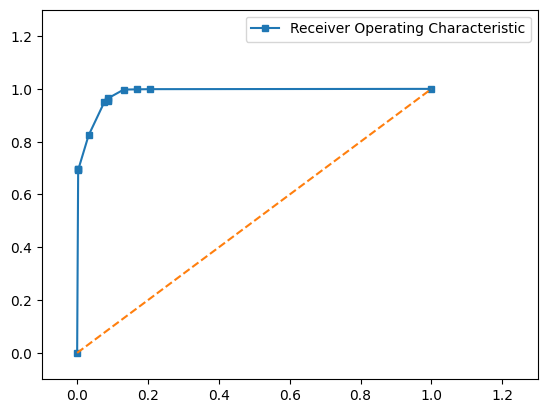

In [ ]:
# roc
plt.plot(roc_x, roc_y, 's-', markersize = 4, label = 'Receiver Operating Characteristic')

# y=x line
plt.plot([0, 1], [0, 1], '--')
plt.xlim(-0.1, 1.3)
plt.ylim(-0.1, 1.3)
plt.legend(loc='upper right')

plt.show()

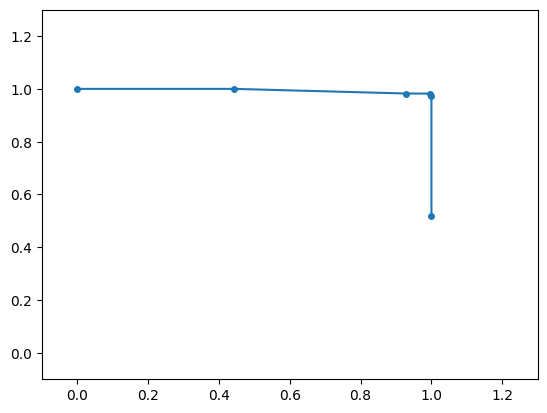

In [ ]:
# precision-recall
plt.plot(pr_x, pr_y, 'o-', markersize = 4, label = 'Precision Recall')
plt.xlim(-0.1, 1.3)
plt.ylim(-0.1, 1.3)

plt.show()

In [ ]:
def integrate_traps(x_values, y_values):
  return sum([(y_values[i] + y_values[i + 1]) * (x_values[i + 1] - x_values[i]) / 2 for i in range(len(x_values) - 1)])

In [ ]:
print("Area under curve ROC = {}".format(integrate_traps(roc_x, roc_y)))
print("Area under curve PR = {}".format(integrate_traps(pr_x, pr_y)))

Area under curve ROC = 0.9942808002001602
Area under curve PR = 0.994460119898327
